<a href="https://colab.research.google.com/github/cydal/tsExtract/blob/master/examples/tsextract_example_notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## tsextract Time Series Preprocessing

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor

## Load Data

In [2]:
df = pd.read_csv("DAYTON_hourly.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime")

# pip install package

In [4]:
! pip install tsextract

     |████████████████████████████████| 9.5MB 6.7MB/s 
     |████████████████████████████████| 25.9MB 12.5MB/s 
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.5.4 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
df.head()

,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1596.0
2004-12-31 02:00:00,1517.0
2004-12-31 03:00:00,1486.0
2004-12-31 04:00:00,1469.0
2004-12-31 05:00:00,1472.0


## Import tsextract

In [7]:
from tsextract.feature_extraction.extract import build_features
from tsextract.domain.statistics import median, mean, skew, kurtosis

In [8]:
feature_request = {
    "window":[15], 
    "window_statistic":[5, 10, median],
    "difference_statistic":[15, 10, kurtosis], 
    "force_statistic":[15, 10, skew]
}

Features requested - 

* Window Size of 15
* Median of sliding window of 5 - 10
* Differencing window size of 15 & Lag of 10 - Kurtosis
* Force window size of 15, Lag of 10 - Skew

In [9]:
data = build_features(df["DAYTON_MW"], feature_request, include_tzero=False, target_lag=5)

Main function build_features Arguments - 
* Time series data
* Features request dictionary
* Option to include t+0
* Target Variable - shifted 5 steps forward

# Feature Scaling

In [16]:
scaler_features = StandardScaler().fit(data[data.columns.values[:-1]])
scaled_features = scaler_features.transform(data[data.columns.values[:-1]])

scaler_label = StandardScaler().fit(np.array(data[data.columns.values[-1]]).reshape(-1, 1))
scaled_label = scaler_label.transform(np.array(data[data.columns.values[-1]]).reshape(-1, 1))

Data is scaled using Standard Scaler. Scales to 0 mean and unit variance. 

# Split Data

In [26]:
### Split data using train proportion of 0.8
train_size = int(scaled_features[:, :-1].shape[0] * 0.8)


X_train, y_train = scaled_features[:train_size, :], scaled_label[:train_size, -1]
X_test, y_test = scaled_features[train_size:, :], scaled_label[train_size:, -1]

# Model

In [27]:
clf = GradientBoostingRegressor(random_state=0)
clf.fit(X_train, y_train.reshape(-1, ))

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
train_score, test_score = clf.score(X_train, y_train), clf.score(X_test, y_test)

In [29]:
print(f"Train Score is {train_score} \n & Test Score is {test_score}")

Train Score is 0.7365769421286801 
 & Test Score is 0.7091159698577534


# Visualize Performance

In [30]:
from tsextract.plots.eval import *

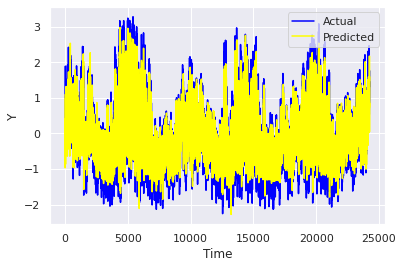

In [31]:
actualPred(y_test.reshape(-1,), clf.predict(X_test))

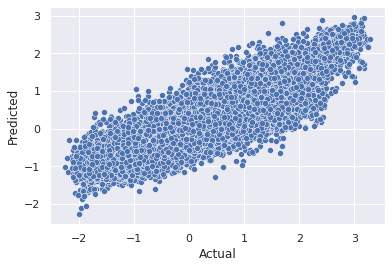

In [32]:
scatter(y_test.reshape(-1,), clf.predict(X_test))

The scatterplot shows a high degree of positive correlation between the Actual and Predicted values. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


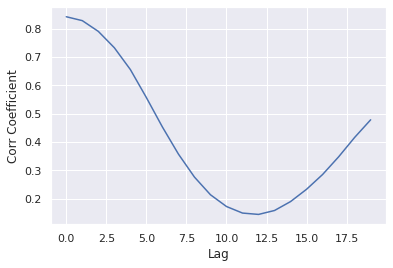

In [33]:
get_lag_corr(y_test, clf.predict(X_test), 20)

We see a high correlation at 0 and a gradual drop  after that. A sharp drop indicates a high confidence while a gradual drop implies less. Sharp drops are typically preferred. 

In [34]:
scaler_label.inverse_transform(clf.predict(X_test).reshape(-1, 1))

array([[1998.54772764],
       [1987.58084437],
       [2034.45766187],
       ...,
       [2198.44705729],
       [2245.48435296],
       [2373.98202474]])